In [84]:
from statistics import LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


In [85]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:

n_rows = 300

np.random.seed(26)

x = np.random.rand(n_rows)*2
y = 2*x
y2 = 2*x**2+x

def true_y(x):
    return 2*x
    
def true_y2(x):
    return 2*x**2+x

noise = np.random.normal(0, 1, n_rows)

y+=noise
y2+=noise


df1 = pd.DataFrame({
    'x':x,
    'y':y
})

df1_true = pd.DataFrame({
    'x':x,
    'y':true_y(x)
})

df2 = pd.DataFrame({
    'x':x,
    'y':y2
})

df2_true = pd.DataFrame({
    'x':x,
    'y':true_y2(x)
})

X1_true = np.linspace(min(df1['x']), max(df1['x']), 100)
y1_true = true_y(X1_true)

X2_true = np.linspace(min(df2['x']), max(df2['x']), 100)
y2_true = true_y2(X2_true)


In [87]:
df1.describe()

,x,y
count,300.000000,300.000000
mean,1.012228,2.010124
std,0.595331,1.569154
min,0.010089,-1.909516
25%,0.513945,0.905340
50%,1.018307,2.033289
75%,1.564147,3.202166
max,1.993416,5.975161


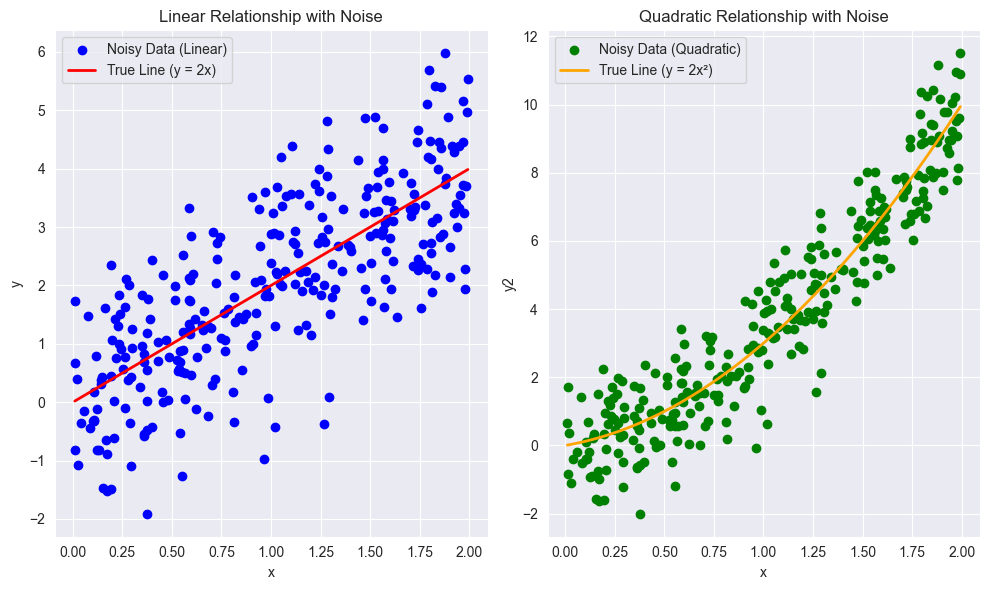

In [88]:
plt.figure(figsize = (10,6))

plt.subplot(1, 2, 1)
plt.scatter(df1['x'], df1['y'], label='Noisy Data (Linear)', color='blue')
plt.plot(X1_true, y1_true, label='True Line (y = 2x)', color='red', linewidth=2)
plt.title('Linear Relationship with Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(df2['x'], df2['y'], label='Noisy Data (Quadratic)', color='green')
plt.plot(X2_true, y2_true, label='True Line (y = 2x²)', color='orange', linewidth=2)
plt.title('Quadratic Relationship with Noise')
plt.xlabel('x')
plt.ylabel('y2')
plt.legend()

plt.tight_layout()
plt.show()



since we are creating synthetic data here, the purpose of adding gaussian noise here is such that we do not simply have a straight line, but actually something more resembling real data (since the y values are by nature dependent on x).

In [89]:
def poly_regression(df, degree):
    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(df['x'].values.reshape(-1,1))
    
    model = LinearRegression()
    model.fit(x_poly, df['y'])
    y_pred_poly = model.predict(x_poly)
    
    return y_pred_poly
    

<function matplotlib.pyplot.show(close=None, block=None)>

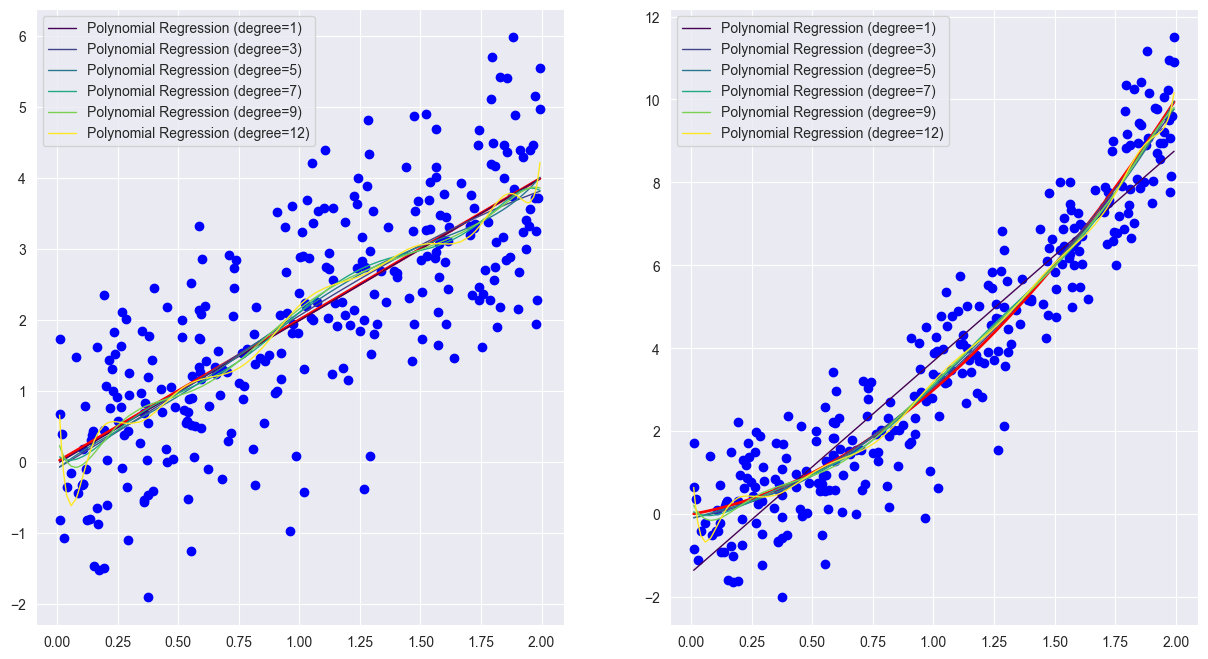

In [90]:
degrees = [1, 3, 5, 7, 9, 12]
preds = []
preds2 = []

for i in degrees:
    preds.append(poly_regression(df1, i))
    preds2.append(poly_regression(df2, i))
    

plt.figure(figsize=(15,8))


plt.subplot(1, 2, 1)
plt.scatter(df1['x'], df1['y'], color='blue')
plt.plot(X1_true, y1_true, color='red', linewidth=2)

colors = plt.cm.viridis(np.linspace(0, 1, len(degrees)))

sorted_index = np.argsort(df1['x'])
for j in range(len(degrees)):
    sorted_preds = np.array(preds[j])[sorted_index]
    plt.plot(df1['x'].values[sorted_index], sorted_preds, color= colors[j], label=f'Polynomial Regression (degree={degrees[j]})', linewidth=1)
    
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(df2['x'], df2['y'], color='blue')
plt.plot(X2_true, y2_true, color='red', linewidth=2)

colors = plt.cm.viridis(np.linspace(0, 1, len(degrees)))

sorted_index2 = np.argsort(df2['x'])
for j in range(len(degrees)):
    sorted_preds = np.array(preds2[j])[sorted_index2]
    plt.plot(df2['x'].values[sorted_index2], sorted_preds, color= colors[j], label=f'Polynomial Regression (degree={degrees[j]})', linewidth=1)
    
plt.legend()




plt.show

    



1: a polynomial regression model can use a polynomial function of specified degree to create a regression line instead of a linear one.

2: the higher the degree in the polynomials, the less bias the model will have, and the more variance. In essence, the model becomes more prone to overfitting the higher the degree of the polynomial

In [91]:
#different version of the above function for better fit with the function below

def poly_regression_2(xs, ys, x_test, degree):
    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(xs)
    
    model = LinearRegression()
    model.fit(x_poly, ys)
    x_test_poly = poly.transform(x_test)
    y_pred_poly = model.predict(x_test_poly)
    
    return y_pred_poly
    

In [92]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

def bias_var_est(df_train, df_test, true_ys, model, n_bootstrap):
    n = df_test.shape[0]
    preds = np.zeros((n_bootstrap, n))
    
    for i in range(n_bootstrap):
        X_train, y_train = resample(df_train['x'], df_train['y'], replace=True)
        
        y_pred = poly_regression_2(X_train.values.reshape(-1,1), y_train.values.reshape(-1,1), df_test['x'].values.reshape(-1,1), model)
        
        preds[i, :] = y_pred.flatten()
    
    y_avg = np.mean(preds, axis=0)
    vars = np.mean((preds - y_avg)**2, axis=0)
    MSEs = np.mean((preds - df_test['y'].values)**2, axis=0)

    biases = np.zeros(n)
    noise = np.zeros(n)
    for i in range(n):
        biases[i] = (y_avg[i] - true_ys[i])**2
        noise[i] = MSEs[i] - biases[i] - vars[i]

    bias = np.mean(biases) 
    var = np.mean(vars)
    avg_noise = np.mean(noise)
    total_error = bias + var + avg_noise
    return bias, var, avg_noise, total_error
    
    

3.7114130011174713


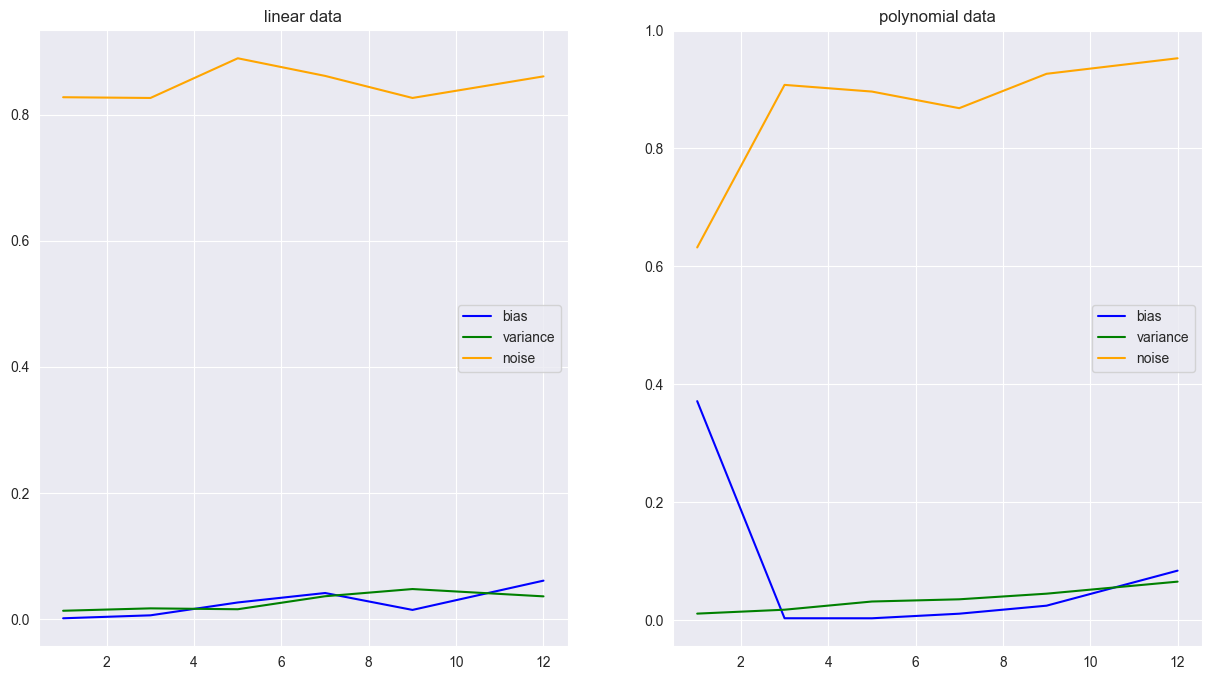

In [93]:
n_bootstrap = 10

df_train1, df_test1 = train_test_split(df1, test_size=0.2)
true_ys1 = true_y(df_test1['x'].values)
print(true_ys1[0])

biases_lin = []
vars_lin = []
noise_lin = []

for i in degrees:
    bias, var, noise, error = bias_var_est(df_train1, df_test1, true_ys1, i, n_bootstrap)
    
    biases_lin.append(bias)
    vars_lin.append(var)
    noise_lin.append(noise)
    
df_train2, df_test2 = train_test_split(df2, test_size=0.2)
true_ys2 = true_y2(df_test2['x'].values)
    
biases_poly = []
vars_poly = []
noise_poly = []

for j in degrees:
    bias, var, noise, error = bias_var_est(df_train2, df_test2, true_ys2, j, n_bootstrap)
    
    biases_poly.append(bias)
    vars_poly.append(var)
    noise_poly.append(noise)
    


plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)

plt.plot(degrees, biases_lin, color='blue', label='bias')
plt.plot(degrees, vars_lin, color='green', label='variance')
plt.plot(degrees, noise_lin, color='orange', label='noise')
plt.title('linear data')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(degrees, biases_poly, color='blue', label='bias')
plt.plot(degrees, vars_poly, color='green', label='variance')
plt.plot(degrees, noise_poly, color='orange', label='noise')
plt.title('polynomial data')
plt.legend()

plt.show()


